In [ ]:
#!pip install poetry==1.5.1
#!poetry install

In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.metrics import mean_absolute_error

sns.set()
SMALL_SIZE = 12
MEDIUM_SIZE = SMALL_SIZE + 3

plt.rc('font', size=SMALL_SIZE)           # controls default text sizes\\n\",\n",
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title\\n\",\n",
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels\\n\",\n",
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\\n\",\n",
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\\n\",\n",
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize\\n\",\n",
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title\\n\",\n",
plt.rc('figure', figsize=(7, 2))
plt.rc('figure', dpi=200)

In [ ]:
consumption = pd.read_pickle("data/consumption.pkl")
print(consumption.shape)
consumption.head()

In [ ]:
TARGET = "total_consumption"

In [ ]:
# Things to understand from time series EDA:
# - What is the right time-resolution for our problem? Sometimes TS data might be events, 
# sometimes it might come aggregated at too granular level, sometimes we are constrained
# by the business context to define a resolution.


consumption[[TARGET]].describe().round(2).T

In [ ]:
consumption[[TARGET]].hist(bins=50)

In [ ]:
# We can see that there are a lot of zeros in the data, which means that the distribution is sparse/zero-inflated.
# We can see that the mean is higher than the median, which means that the distribution is skewed to the right.
# Implications for modelling:
# - If we can avoid predicting at a minute-level, we should.
# - If not, predicting the mean is not a good idea, so a linear model might not be a good idea.
# - If we want to use a linear model, we could to split the problem in two: predict whether there is consumption or not, and then predict the amount of consumption.
# - Otherwise we could use a non-linear model, like a tree-based model.
#
# For the sake of this analysis, we're going to aggregate data to a 5 minute level resolution, but first we'll check for missing data.

In [ ]:
consumption['date'].value_counts().value_counts()

In [ ]:
# - There are 1440 minutes in a day, so we should have 1440 rows per day. Most days have 1440 rows, but some have less.
# - It's often practical to represent every possible time slot for data processing reasons, so we should add the missing rows.
# - Then we could try to address the missing values at a minute-level resolution. For now, we'll aggregate first to an hourly resolution
# and then we'll address the missing values if there are any. It's not as correct, but it's easier to do.

# To aggregate there are two approaches:
# - Groupby: create a column with the desired resolution and group by. As a result we might still have missing rows.
# - Resample: less code, results in no missing rows, the missing slots are filled with 0s. Similar to a groupby+asfreq+fillna 0.
# If we choose the second one, we lose visibility of what slots are missing, but it's also a simpler approach.

In [ ]:
consumption_agg = consumption.resample('H')[[TARGET]].sum()
consumption_agg['date'] = consumption_agg.index.date
consumption_agg.describe().round(2).T

In [ ]:
consumption_agg['date'].value_counts().value_counts()

In [ ]:
consumption_agg.isnull().sum()

In [ ]:
consumption_agg.hist(bins=50)

In [ ]:
## It looks like a much easier problem to solve: much less sparse, but still quite skewed and it looks like there are a group 
## of observations around 1-1.5.

# EDA

In [ ]:
consumption.index.min(), consumption.index.max()

In [ ]:
px.line(consumption_agg.reset_index(), x="time", y="total_consumption", title="Energy consumption")

In [ ]:
for resolution in ['M', 'Q', 'Y']:
    fig, ax = plt.subplots(figsize=(20, 6))
    consumption_agg['total_consumption'].resample(resolution).sum().iloc[1:-1].plot(ax=ax, marker='o')
    ax.set_title(f'consumption {resolution} resolution')

### We saw before there is an hourly and a weekday pattern going on, let's dive into those. How strong are them? How much variance is there around them?

In [ ]:
consumption_agg['quarter'] = consumption_agg.index.quarter
consumption_agg['year'] = consumption_agg.index.year
consumption_agg['month'] = consumption_agg.index.month
consumption_agg['hour'] = consumption_agg.index.hour
consumption_agg['day_of_week'] = consumption_agg.index.dayofweek
#consumption_agg['day_of_week_hour'] = consumption_agg.apply(lambda x: f'{x["day_of_week"]}_{x["hour"]}', axis=1)

time_features = [
    'quarter',
    'year',
    'month',
    'hour',
    'day_of_week',
    #'day_of_week_hour',
]
for f_name in time_features:
    fig, ax = plt.subplots(figsize=(20, 6))
    sns.boxplot(x=f_name, y="total_consumption", data=consumption_agg, ax=ax, color='b')
    sns.stripplot(data=consumption_agg, x=f_name, y='total_consumption', ax=ax, linewidth=1, color='b', alpha=.8)
    ax.set_title(f'Average consumption by {f_name}')


In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax = consumption_agg['total_consumption'].diff().plot(ax=ax)
print(consumption_agg['total_consumption'].diff().mean().round(3))
ax.axhline(consumption_agg['total_consumption'].diff().mean(), color='red')

# Modelling

### Task: predict next day of hourly energy consumption

In [ ]:
consumption_agg['date'].min(), consumption_agg['date'].max()

In [ ]:
train_time = (str(consumption_agg['date'].min()), '2008-10-01')
test_time = ('2008-10-01', '2008-10-01')
modelling_data = consumption_agg[train_time[0]:test_time[1]].copy()
train_df = modelling_data.loc[modelling_data.index < test_time[0]]
test_df = modelling_data.loc[test_time[0]:test_time[1]]
print(f'Start of train: {train_df.index.min()}')
print(f'End of train: {train_df.index.max()}')
print(f'Start of test: {test_df.index.min()}')
print(f'End of test: {test_df.index.max()}')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(train_df['total_consumption'].iloc[-300:], label='train values')
ax.plot(test_df['total_consumption'], label='test values')
ax.legend()

In [ ]:
def plot_predictions(train_df, test_df, short_forecast, long_forecast=None, fitted=None, name=None, days_before=1):
    time_to_viz = pd.Timestamp(test_df.index.min()) - pd.Timedelta(days=days_before)
    real = pd.concat([train_df, test_df]).loc[time_to_viz:, 'total_consumption']
    fitted = fitted.loc[time_to_viz:] if fitted is not None else None
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(real, label='real values')
    if fitted is not None:
        ax.plot(fitted, label='fitted values')

    ax.plot(short_forecast, label='forecasted values (short)')
    if long_forecast is not None:
        ax.plot(long_forecast, label='forecasted values (long)')
    ax.set_title(name)
    ax.legend()
    return round(mean_absolute_error(test_df['total_consumption'], short_forecast), 2)

## Naive model: recursive rolling mean

In [ ]:
import mlflow

mlflow.set_experiment('predicting_hourly_consumption')

$$MovingAverage(k) = \sum_{i=n-k+1}^{n}{p_i}$$

In [ ]:
def rolling_mean_forecast(series, window, steps_ahead):
    """
    Forecast next steps_ahead values using a rolling mean based on the specified window size.

    :param series: Pandas Series, the time series data
    :param window: int, the window size for the rolling mean
    :param steps_ahead: int, number of future predictions to generate
    :return: list, predicted values
    """
    # Start with the original series and make a copy to avoid modifying the original
    extended_series = series.copy()
    fitted_values = series.rolling(window=window).mean()

    # Generate predictions iteratively
    predictions = []
    for _ in range(steps_ahead):
        # Calculate the current rolling mean
        current_prediction = extended_series.rolling(window=window).mean().iloc[-1]
        # Append the prediction to the results
        predictions.append(current_prediction)
        # Append current prediction to the series to use it for the next prediction
        extended_series = pd.concat([extended_series, pd.Series([current_prediction])])
    
    return predictions, fitted_values

WINDOW = 3
with mlflow.start_run():
    predictions, fitted_values = rolling_mean_forecast(train_df['total_consumption'], window=WINDOW, steps_ahead=24)
    predictions = pd.Series(predictions, index=test_df.index)
    loss = plot_predictions(
        train_df,
        test_df,
        short_forecast=predictions,
        long_forecast=None,
        fitted=fitted_values,
        name="rolling mean",
        days_before=7,
    )
    mlflow.log_param('window', WINDOW)
    mlflow.log_param('model_name', 'rolling_mean')
    mlflow.log_metric('mae', loss)

In [ ]:
# I think this implementation doesn't work for many-days ahead prediction.

import pandas as pd


def rolling_mean_sliced_forecast(data: pd.DataFrame, window, steps_ahead):
    """
    Forecast future values using a rolling mean based on specific hourly data across days.
    This function calculates the rolling mean for values at a specified hour from previous days
    and predicts future values for the same hour.

    :param data: Pandas DataFrame, the time series data with a datetime index
    :param window: int, the window size for the rolling mean
    :param steps_ahead: int, number of future predictions to generate
    :return: tuple, (list of fitted values, list of predicted values)
    """
    assert data.index.name == "time", "Index should be named 'time'"
    assert isinstance(data, pd.DataFrame), "Data should be a DataFrame"
    test_df = pd.DataFrame(
        {
            "time": pd.date_range(
                start=data.index.max(),
                periods=steps_ahead + 1,
                freq="H",
                inclusive="neither",
            ),
            "total_consumption": [np.nan] * steps_ahead,
        }
    ).set_index("time")
    data = pd.concat([data, test_df]).reset_index()
    data["hour"] = data["time"].dt.hour
    shifted_consumption = (
        data.set_index(["time", "hour"]).groupby("hour")["total_consumption"].shift()
    )
    preds = (
        shifted_consumption.groupby("hour")
        .rolling(window=window, min_periods=1)
        .mean()
        .reset_index(level=[0, 2], drop=True)
        .sort_index()
    )
    return preds.iloc[-steps_ahead:], preds


def test_generate_hourly_predictions_pandas_happy_path():
    # Prepare test data
    data = pd.DataFrame(
        {
            "time": pd.date_range(start="2023-01-01", periods=48, freq="H"),
            "total_consumption": range(48),  # Simple increasing pattern over 24 hours
        }
    ).set_index("time")

    # Function under test
    predictions, _ = rolling_mean_sliced_forecast(data, window=3, steps_ahead=24)

    predicted_times = [
        pd.Timestamp("2023-01-03 00:00:00"),
        pd.Timestamp("2023-01-03 12:00:00"),
    ]
    # For hour 0, the last 2 values are 0 and 24, so the prediction should be (0 + 24) / 2 = 12
    # For hour 12, the last 2 values are 12 and 36, so the prediction should be (12 + 36) / 2 = 24

    # Check the predicted values
    expected_predictions = pd.DataFrame(
        {
            "time": predicted_times,
            "predicted_consumption": [12.0, 24.0],
            "hour": [0, 12],
        }
    )

    # Comparing generated predictions for hour 0 to expected predictions
    predictions = predictions.to_frame("predicted_consumption")
    predictions["hour"] = predictions.index.hour
    pd.testing.assert_frame_equal(
        predictions[predictions["hour"].isin([0, 12])].reset_index(),
        expected_predictions,
    )


test_generate_hourly_predictions_pandas_happy_path()

In [ ]:
WINDOW = 12

with mlflow.start_run():
    predictions, fitted_values = rolling_mean_sliced_forecast(train_df[['total_consumption']], window=WINDOW, steps_ahead=24)
    loss = plot_predictions(
        train_df,
        test_df,
        short_forecast=predictions,
        long_forecast=None,
        fitted=fitted_values,
        name="rolling_mean_sliced",
        days_before=7,
    )
    mlflow.log_param('window', WINDOW)
    mlflow.log_param('model_name', 'rolling_mean_sliced')
    mlflow.log_metric('mae', loss)

## ARIMA

### ARIMA(1,0,1) Model:

This model includes one AR term and one MA term. It is represented as follows:

$
y_t = c + φ₁y_{t-1} + θ₁ε_{t-1} + ε_t
$

Where:
- `y_t` is the value of the series at time t.
- `c` is a constant.
- `φ₁` is the coefficient for the first autoregressive lag (AR term).
- `θ₁` is the coefficient for the first moving average lag (MA term).
- `ε_t` is the error term at time t, which is a white noise error process.

Intuition
- The AR part $(φ₁y_{t-1})$ suggests that the current value of the series is correlated with its immediately previous value, adjusted by the coefficient φ₁.
- The MA part $(θ₁ε_{t-1})$ adjusts the current value of the series based on the error made by the previous forecast, scaled by θ₁.


Teaching note: for now, focus on AR part

In [ ]:
from sktime.forecasting.arima import ARIMA
from funcs import train_arima

order = (1, 0, 0)
_train_df = train_df['total_consumption'].copy()
_train_df.to_pickle('train.pkl')
arima = train_arima('train.pkl', order=order)

with mlflow.start_run():
    predictions = arima.predict(test_df.index)
    fitted_values = arima.predict(_train_df.index)
    loss = plot_predictions(
        train_df,
        test_df,
        short_forecast=predictions,
        long_forecast=None,
        fitted=fitted_values,
        name="arima",
        days_before=7,
    )
    mlflow.log_param('model_name', 'arima')
    mlflow.log_param('order', order)
    mlflow.log_metric('mae', loss)

In [ ]:
order = (24, 0, 0)

_train_df = train_df['total_consumption'].copy()
_train_df.to_pickle('train.pkl')
arima = train_arima('train.pkl', order=order)

with mlflow.start_run():
    predictions = arima.predict(test_df.index)
    fitted_values = arima.predict(_train_df.index)
    loss = plot_predictions(
        train_df,
        test_df,
        short_forecast=predictions,
        long_forecast=None,
        fitted=fitted_values,
        name="arima",
        days_before=7,
    )
    mlflow.log_param('model_name', 'arima')
    mlflow.log_param('order', order)
    mlflow.log_metric('mae', loss)

In [2]:
# teaching note: go over I component, trends and different trends

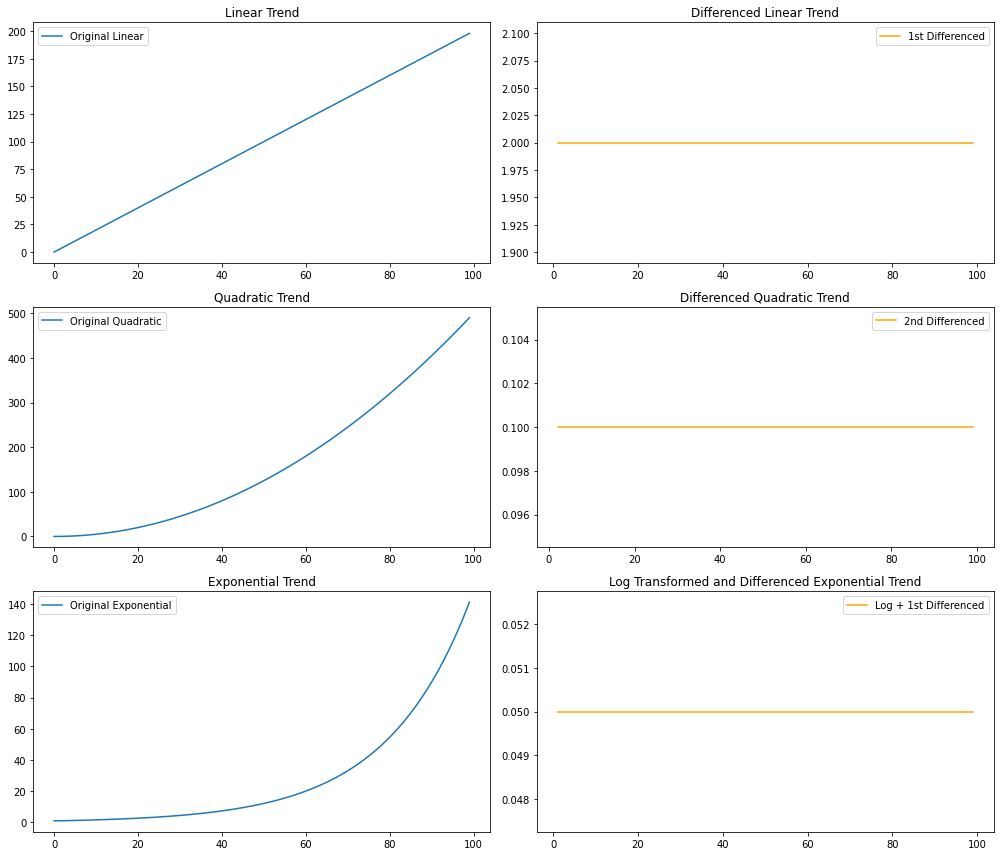

In [12]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
t = np.arange(100)
linear_series = 2 * t
quadratic_series = 0.05 * t**2
exponential_series = np.exp(0.05 * t)

linear_diff = np.diff(linear_series, n=1)
quadratic_diff = np.round(np.diff(quadratic_series, n=2), 3)
log_exponential = np.log(exponential_series)
log_exponential_diff = np.round(np.diff(log_exponential, n=1), 3)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axes[0, 0].plot(t, linear_series, label='Original Linear')
axes[0, 0].set_title('Linear Trend')
axes[0, 1].plot(t[1:], linear_diff, label='1st Differenced', color='orange')
axes[0, 1].set_title('Differenced Linear Trend')

axes[1, 0].plot(t, quadratic_series, label='Original Quadratic')
axes[1, 0].set_title('Quadratic Trend')
axes[1, 1].plot(t[2:], quadratic_diff, label='2nd Differenced', color='orange')
axes[1, 1].set_title('Differenced Quadratic Trend')

axes[2, 0].plot(t, exponential_series, label='Original Exponential')
axes[2, 0].set_title('Exponential Trend')
axes[2, 1].plot(t[1:], log_exponential_diff, label='Log + 1st Differenced', color='orange')
axes[2, 1].set_title('Log Transformed and Differenced Exponential Trend')

for ax_row in axes:
    for ax in ax_row:
        ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
order = (1, 1, 0)

_train_df = train_df['total_consumption'].copy()
_train_df.to_pickle('train.pkl')
arima = train_arima('train.pkl', order=order)

with mlflow.start_run():
    predictions = arima.predict(test_df.index)
    fitted_values = arima.predict(_train_df.index)
    loss = plot_predictions(
        train_df,
        test_df,
        short_forecast=predictions,
        long_forecast=None,
        fitted=fitted_values,
        name="arima",
        days_before=7,
    )
    mlflow.log_param('model_name', 'arima')
    mlflow.log_param('order', order)
    mlflow.log_metric('mae', loss)

In [ ]:
# teaching note: go over MA part

In [ ]:
order = (1, 1, 1)

_train_df = train_df['total_consumption'].copy()
_train_df.to_pickle('train.pkl')
arima = train_arima('train.pkl', order=order)

with mlflow.start_run():
    predictions = arima.predict(test_df.index)
    fitted_values = arima.predict(_train_df.index)
    loss = plot_predictions(
        train_df,
        test_df,
        short_forecast=predictions,
        long_forecast=None,
        fitted=fitted_values,
        name="arima",
        days_before=7,
    )
    mlflow.log_param('model_name', 'arima')
    mlflow.log_param('order', order)
    mlflow.log_metric('mae', loss)

In [ ]:
order = (12, 1, 12)

_train_df = train_df['total_consumption'].copy()
_train_df.to_pickle('train.pkl')
arima = train_arima('train.pkl', order=order)
arima.summary()

with mlflow.start_run():
    predictions = arima.predict(test_df.index)
    fitted_values = arima.predict(_train_df.index)
    loss = plot_predictions(
        train_df,
        test_df,
        short_forecast=predictions,
        long_forecast=None,
        fitted=fitted_values,
        name="arima",
        days_before=7,
    )
    mlflow.log_param('model_name', 'arima')
    mlflow.log_param('order', order)
    mlflow.log_metric('mae', loss)

In [ ]:
from funcs import train_auto_arima

with mlflow.start_run():
    _train_df = train_df['total_consumption'].iloc[-6000:].copy()
    _train_df.to_pickle('train.pkl')
    auto_arima = train_auto_arima('train.pkl', seasonal=False, suppress_warnings=True, max_d=1, max_p=48, max_q=48)
    predictions = auto_arima.predict(test_df.index)
    fitted_values = auto_arima.predict(_train_df.index)
    loss = plot_predictions(
        train_df,
        test_df,
        short_forecast=predictions,
        long_forecast=None,
        fitted=fitted_values,
        name="arima",
        days_before=7,
    )
    mlflow.log_param('model_name', 'auto_arima')
    mlflow.log_param('order', auto_arima.get_fitted_params()['order'])
    mlflow.log_metric('mae', loss)

AutoARIMA uses the AIC to decide by default:

$$
\text{AIC} = 2k - 2\ln(L)
$$

where:
- $k$ is the number of parameters in the model.
- $L$ is the maximum value of the likelihood function for the model.


In [ ]:
auto_arima.summary()

In [ ]:
# Teaching note
## So far, the best model is the sliced rolling mean... Why do you think that is? Can we improve it with what we know?

# Discuss:
# ARIMA with many lags in order to capture the seasonality
# sliced ARIMA 

## Extending ARIMA: SARIMA

$$SARIMA(p,d,q)(P,D,Q)_m\\
\\
SARIMA(1,0,1)(2,0,2)_{24} = y_t = (a_1  y_{t-1}+ b_1 e_{t-1}) (A_1 y_{t-24}+A_2 y_{t-48}+B_1  e_{t-24}+B_2  e_{t-48}) + \alpha$$

In [ ]:
with mlflow.start_run():

    order = (1, 1, 1)
    seasonal_order = (2, 1, 2, 24)
    
    
    _train_df = train_df["total_consumption"].iloc[-3000:].copy()
    _train_df.to_pickle('train_df.pkl')
    sarima = train_arima('train_df.pkl', order=order, seasonal_order=seasonal_order)
    loss = plot_predictions(
        train_df,
        test_df,
        sarima.predict(test_df.index),
        None,
        sarima.predict(_train_df.index),
        name="sarima",
        days_before=10,
    )
    mlflow.log_param("model_name", "sarima")
    mlflow.log_param("order", order)
    mlflow.log_param("seasonal_order", seasonal_order)
    mlflow.log_metric("mae", loss)

In [ ]:
with mlflow.start_run():

    order = (1, 1, 1)
    seasonal_order = (3, 1, 3, 24)
    
    
    _train_df = train_df["total_consumption"].iloc[-3000:].copy()
    _train_df.to_pickle('train_df.pkl')
    sarima = train_arima('train_df.pkl', order=order, seasonal_order=seasonal_order)
    loss = plot_predictions(
        train_df,
        test_df,
        sarima.predict(test_df.index),
        None,
        sarima.predict(_train_df.index),
        name="sarima",
        days_before=10,
    )
    mlflow.log_param("model_name", "sarima")
    mlflow.log_param("order", order)
    mlflow.log_param("seasonal_order", seasonal_order)
    mlflow.log_metric("mae", loss)

In [44]:
# check mle_retvals

{'intercept': 4.951462228083683e-07,
 'ar.L1': 0.4698883951445278,
 'ma.L1': -0.9740846426211611,
 'ar.S.L24': -1.6512673703330474,
 'ar.S.L48': -0.8376875040491436,
 'ar.S.L72': 0.0329397230074416,
 'ma.S.L24': 0.6730809844018271,
 'ma.S.L48': -0.7953937059828303,
 'ma.S.L72': -0.876870254136691,
 'sigma2': 0.19745258063274054,
 'aic': 3797.3682310978975,
 'aicc': 3797.4424551194898,
 'bic': 3857.348224277695,
 'hqic': 3818.952059600913}

In [45]:
pd.concat([train_df, test_df])

,total_consumption,date,quarter,year,month,hour,day_of_week
time,,,,,,,
2006-12-16 17:00:00,0.626002,2006-12-16,4,2006,12,17,5
2006-12-16 18:00:00,1.415013,2006-12-16,4,2006,12,18,5
2006-12-16 19:00:00,1.087021,2006-12-16,4,2006,12,19,5
2006-12-16 20:00:00,1.007027,2006-12-16,4,2006,12,20,5
2006-12-16 21:00:00,1.058039,2006-12-16,4,2006,12,21,5
...,...,...,...,...,...,...,...
2008-10-01 19:00:00,0.351740,2008-10-01,4,2008,10,19,2
2008-10-01 20:00:00,1.296327,2008-10-01,4,2008,10,20,2
2008-10-01 21:00:00,0.983605,2008-10-01,4,2008,10,21,2


In [63]:
# Teaching note
# If there's time: skip the 'shift' code line to show a case of data leak and how to debug it.

from xgboost import XGBRegressor


f_names = ["month", "year", "quarter", "hour", "day_of_week"]
# We need to concatenate train and test df to generate features for the test set, but we need to be careful not to use the test set for training.
train_indices = train_df.index
test_indices = test_df.index
feature_matrix = pd.concat([train_df, test_df])  # .iloc[:-1]
for lag in range(1, 6):
    window = lag
    feature_matrix[f"consumption_daily_lag_{lag}"] = feature_matrix.groupby("hour")[
        "total_consumption"
    ].shift(lag)
    time_features = (
        feature_matrix.groupby("hour")[f"consumption_daily_lag_1"]
        .rolling(window=window, min_periods=1)
        .agg(["mean", "std", "max", "min", "median"])
        .reset_index(level=0, drop=True)
    )
    time_features.columns = [
        f"consumption_rolling_{window}_{col}_hour" for col in time_features.columns
    ]
    feature_matrix = pd.concat([feature_matrix, time_features], axis=1)
    f_names.append(f"consumption_daily_lag_{lag}")
    f_names.extend(time_features.columns)


_train_df = feature_matrix.loc[
    train_indices
].copy()
# _train_df = _train_df.iloc[-3000:].copy()
_test_df = feature_matrix.loc[
    test_indices
].copy()


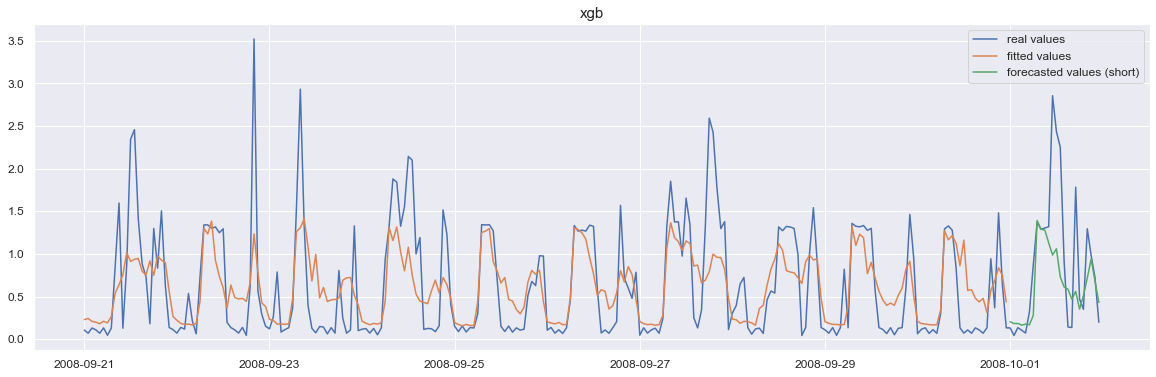

In [70]:
with mlflow.start_run():
    params = dict(n_estimators=1000, max_depth=5, learning_rate=0.01, n_jobs=4)
    xgb = XGBRegressor(**params)
    xgb = xgb.fit(_train_df[f_names], _train_df["total_consumption"])
    preds = pd.Series(xgb.predict(_test_df[f_names]), index=_test_df.index)
    fitted = pd.Series(xgb.predict(_train_df[f_names]), index=_train_df.index)
    loss = plot_predictions(train_df, _test_df, preds, None, fitted, "xgb", 10)

    mlflow.log_params(params)
    mlflow.log_params({"model_name": xgb.__class__.__name__})
    mlflow.log_metric("mae", loss)

<Axes: >

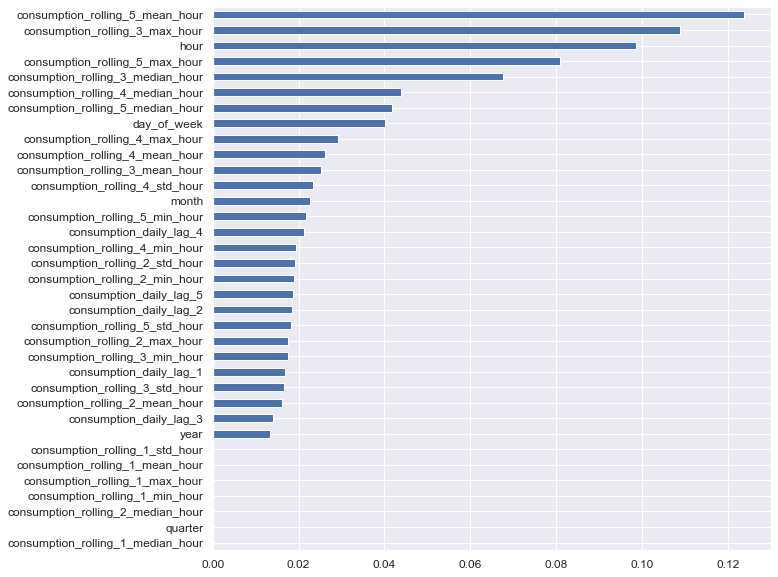

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))
pd.Series(xgb.feature_importances_, index=f_names).sort_values().plot.barh()